# PASCAL VOC : an `Object Detection` Problem 

Source: https://cs.stanford.edu/~roozbeh/pascal-context/

# Setup


In [1]:
import sagemaker

print(sagemaker.__version__)
 
session = sagemaker.Session()

2.16.1


We also need the S3 bucket that you want to use for training and to store the tranied model artifacts. In this notebook, we require a custom bucket that exists so as to keep the naming clean. You can end up using a default bucket that SageMaker comes with as well.

In [13]:
bucket  = "aws-ml-demo-2020"
prefix = 'DEMO-ObjectDetection'

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

print(s3_train_data)
print(s3_validation_data)
print(s3_output_location)

s3://aws-ml-demo-2020/DEMO-ObjectDetection/train
s3://aws-ml-demo-2020/DEMO-ObjectDetection/validation
s3://aws-ml-demo-2020/DEMO-ObjectDetection/output


# Get the name of the Object Detection algorithm in our region

In [14]:
import boto3
from sagemaker import image_uris

region = session.boto_region_name    
container = image_uris.retrieve('object-detection', region)
print(container)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [15]:
role = sagemaker.get_execution_role()

od = sagemaker.estimator.Estimator(container,
                                  role, 
                                  instance_count=1, 
                                  instance_type='ml.p3.2xlarge',
                                  output_path=s3_output_location,
                                  sagemaker_session=session)

The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `10` epochs. Based on our tests, train the model for `30` epochs with similar settings should give us reasonable detection results on the Pascal VOC data.

In [16]:
od.set_hyperparameters(base_network='resnet-50',
                       use_pretrained_model=1,
                       num_classes=20,
                       epochs=30,
                       num_training_samples=16551)

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [17]:
train_data = sagemaker.TrainingInput(s3_train_data, 
                                     distribution='FullyReplicated', 
                                     content_type='application/x-recordio', 
                                     s3_data_type='S3Prefix')

validation_data = sagemaker.TrainingInput(s3_validation_data, 
                                          distribution='FullyReplicated', 
                                          content_type='application/x-recordio', 
                                          s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data}

We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [ ]:
od.fit(inputs=data_channels)

2020-11-24 18:47:02 Starting - Starting the training job...
2020-11-24 18:47:07 Starting - Launching requested ML instances......
2020-11-24 18:48:25 Starting - Preparing the instances for training......
2020-11-24 18:49:22 Downloading - Downloading input data......
2020-11-24 18:50:18 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[11/24/2020 18:50:44 INFO 140630115985216] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sgd', u'_tuning_objective_met

# Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment can be accomplished as follows:

In [19]:
od_predictor = od.deploy(initial_instance_count = 1, instance_type = 'ml.c5.2xlarge')

-------------!

# Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, let us download an image from [PEXELS](https://www.pexels.com/) which the algorithm has so-far not seen. 

In [101]:
file_name = "test-image4.jpeg"

with open(file_name, 'rb') as image:
    f = image.read()
    payload = bytearray(f)

Let us use our endpoint to try to detect objects within this image. Since the image is `jpeg`, we use the appropriate `content_type` to run the prediction job. The endpoint returns a JSON file that we can simply load and peek into.

In [109]:
import json

response = od_predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response = json.loads(response)
#print(response)

The results are in a format that is similar to the .lst format with an addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [110]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """

        img=mpimg.imread(img_file)
        plt.figure(figsize=(15,10))
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()
        
        return plt

For the sake of this notebook, we trained the model with only a few (10) epochs. This implies that the results might not be optimal. To achieve better detection results, you can try to tune the hyperparameters and train the model for more epochs. In our tests, the mAP can reach 0.79 on the Pascal VOC dataset after training the algorithm with `learning_rate=0.0005`, `image_shape=512` and `mini_batch_size=16` for 240 epochs.

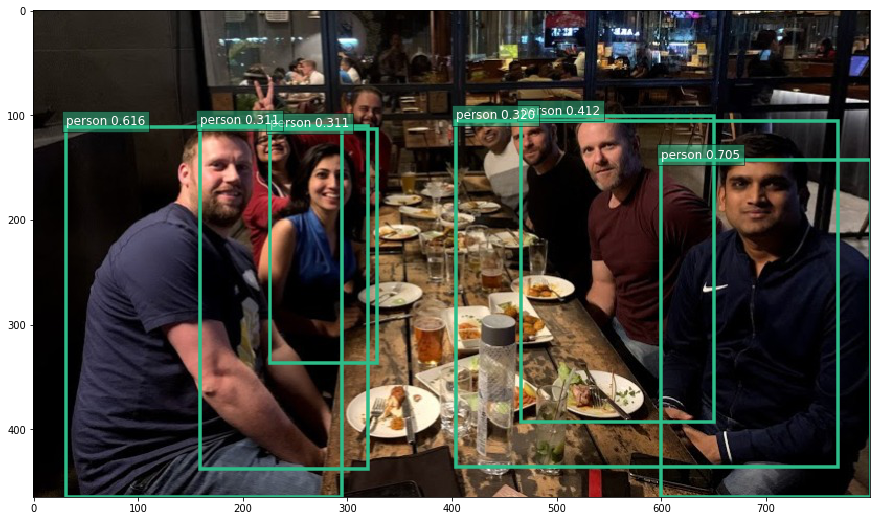

In [111]:
%matplotlib inline 

object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                     'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.30

# Visualize the detections.
plt = visualize_detection(file_name, response['prediction'], object_categories, threshold)

# Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [112]:
#od_predictor.delete_endpoint()